# Cours 5 : Machine Learning - Algorithme CATBOOST

# Préambule

Objectifs du cours :
1. Comprendre les spécificités de CatBoost vs XGBoost et Random Forest
2. Maîtriser le traitement des variables catégorielles
3. Optimiser les hyperparamètres
4. Appliquer CatBoost à un problème de classification financière

# Partie 1 : Introduction théorique

## 1.1 CatBoost : Categorical Boosting

### Rappel : Gradient Boosting
- Vous avez vu XGBoost : optimisation de la fonction de cout en corrigeant de manière récurrente 
- CatBoost est aussi un algorithme de gradient boosting, mais avec des innovations :

### Trois innovations majeures de CatBoost :
1. **Ordered Boosting**
   - XGBoost/LightGBM : peuvent souffrir de "prediction shift" (overfitting sur train)
   - CatBoost utilise un ordre aléatoire différent pour chaque arbre
   - Réduit le risque d'overfitting naturellement   
2. **Gestion native des variables catégorielles**
   - Pas besoin de One-Hot Encoding ou Label Encoding manuel
   - Utilise "Ordered Target Statistics" pour encoder les catégories
   - Évite le target leakage grâce à l'ordered boosting
3. **Arbres symétriques (Oblivious Trees)**
   - Même condition de split à chaque niveau
   - Plus rapide en prédiction
   - Régularisation naturelle

### Quand utiliser CatBoost ?
* Nombreuses variables catégorielles  
* Dataset de taille moyenne à grande  
* Besoin de robustesse sans trop de tuning  
* Problèmes de classification ou régression  

### CatBoost vs XGBoost vs Random Forest
| Critère | CatBoost | XGBoost | Random Forest |
|---------|----------|---------|---------------|
| Variables catégorielles |  Natif |  Preprocessing |  Preprocessing |
| Vitesse d'entraînement | Moyen | Rapide | Très rapide |
| Overfitting | Faible | Moyen | Faible |
| Tuning requis | Minimal | Important | Minimal |
| Interprétabilité | Bonne | Bonne | Moyenne |



# Partie 2 : Mise en pratique - Prédiction de défaut de crédit

## Préparation du workspace

### Import de librairies

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from catboost import CatBoostClassifier, Pool
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")

# Configuration des graphiques
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")

### Import des données

In [2]:
## Chargement du dataset Adult Income (Census)

print("=== Chargement du dataset Adult Income ===\n")
print(
    "Dataset classique de Kaggle/UCI qui illustre parfaitement les forces de CatBoost",
)
print(
    "Objectif : Prédire si le revenu annuel > 50K$ basé sur des caractéristiques socio-démographiques\n",
)

# Chargement depuis UCI
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"

column_names = [
    "age",
    "workclass",
    "fnlwgt",
    "education",
    "education_num",
    "marital_status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "capital_gain",
    "capital_loss",
    "hours_per_week",
    "native_country",
    "income",
]

try:
    df = pd.read_csv(
        url,
        names=column_names,
        sep=r",\s*",
        engine="python",
        na_values="?",
    )
    print("Dataset chargé depuis UCI repository")
except:  # noqa: E722
    print("Impossible de charger depuis UCI, création d'un dataset simulé similaire...")
    # Fallback : créer un dataset similaire
    np.random.seed(42)
    n_samples = 32561

    df = pd.DataFrame(
        {
            "age": np.random.randint(17, 90, n_samples),
            "workclass": np.random.choice(
                [
                    "Private",
                    "Self-emp-not-inc",
                    "Local-gov",
                    "State-gov",
                    "Self-emp-inc",
                    "Federal-gov",
                    "Without-pay",
                ],
                n_samples,
                p=[0.73, 0.08, 0.06, 0.04, 0.03, 0.03, 0.03],
            ),
            "fnlwgt": np.random.randint(12285, 1484705, n_samples),
            "education": np.random.choice(
                [
                    "HS-grad",
                    "Some-college",
                    "Bachelors",
                    "Masters",
                    "Assoc-voc",
                    "Doctorate",
                    "11th",
                    "9th",
                    "7th-8th",
                ],
                n_samples,
                p=[0.32, 0.22, 0.16, 0.05, 0.04, 0.01, 0.04, 0.03, 0.13],
            ),
            "education_num": np.random.randint(1, 16, n_samples),
            "marital_status": np.random.choice(
                [
                    "Married-civ-spouse",
                    "Never-married",
                    "Divorced",
                    "Separated",
                    "Widowed",
                ],
                n_samples,
                p=[0.46, 0.33, 0.14, 0.03, 0.04],
            ),
            "occupation": np.random.choice(
                [
                    "Prof-specialty",
                    "Craft-repair",
                    "Exec-managerial",
                    "Adm-clerical",
                    "Sales",
                    "Other-service",
                    "Machine-op-inspct",
                    "Tech-support",
                ],
                n_samples,
                p=[0.13, 0.13, 0.13, 0.12, 0.11, 0.10, 0.06, 0.22],
            ),
            "relationship": np.random.choice(
                [
                    "Husband",
                    "Not-in-family",
                    "Own-child",
                    "Unmarried",
                    "Wife",
                    "Other-relative",
                ],
                n_samples,
                p=[0.40, 0.26, 0.16, 0.10, 0.05, 0.03],
            ),
            "race": np.random.choice(
                ["White", "Black", "Asian-Pac-Islander", "Amer-Indian-Eskimo", "Other"],
                n_samples,
                p=[0.85, 0.10, 0.03, 0.01, 0.01],
            ),
            "sex": np.random.choice(["Male", "Female"], n_samples, p=[0.67, 0.33]),
            "capital_gain": np.where(
                np.random.random(n_samples) < 0.92,
                0,
                np.random.randint(1, 99999, n_samples),
            ),
            "capital_loss": np.where(
                np.random.random(n_samples) < 0.95,
                0,
                np.random.randint(1, 4356, n_samples),
            ),
            "hours_per_week": np.random.randint(1, 99, n_samples),
            "native_country": np.random.choice(
                [
                    "United-States",
                    "Mexico",
                    "Philippines",
                    "Germany",
                    "Canada",
                    "India",
                    "Other",
                ],
                n_samples,
                p=[0.90, 0.02, 0.01, 0.01, 0.01, 0.01, 0.04],
            ),
        },
    )

    # Création de la cible avec logique réaliste
    income_score = (
        (df["age"] > 35).astype(int) * 20
        + (df["education_num"] > 12).astype(int) * 30
        + (df["hours_per_week"] > 40).astype(int) * 15
        + (df["capital_gain"] > 0).astype(int) * 25
        + (df["marital_status"] == "Married-civ-spouse").astype(int) * 20
        + (df["occupation"].isin(["Exec-managerial", "Prof-specialty"])).astype(int)
        * 15
        + np.random.normal(0, 15, n_samples)
    )
    df["income"] = (income_score > 60).map({True: ">50K", False: "<=50K"})

=== Chargement du dataset Adult Income ===

Dataset classique de Kaggle/UCI qui illustre parfaitement les forces de CatBoost
Objectif : Prédire si le revenu annuel > 50K$ basé sur des caractéristiques socio-démographiques

Dataset chargé depuis UCI repository


### Première visualisation des données

In [3]:
print(f"\n Shape du dataset : {df.shape}")
print(f" Nombre de features : {df.shape[1] - 1}")


 Shape du dataset : (32561, 15)
 Nombre de features : 14


In [4]:
# Nettoyage des valeurs manquantes
print("\n Valeurs manquantes :")
print(df.isnull().sum()[df.isnull().sum() > 0])

# Suppression des lignes avec valeurs manquantes (peu nombreuses)
df = df.dropna()
print(f" Dataset nettoyé : {df.shape}")


 Valeurs manquantes :
workclass         1836
occupation        1843
native_country     583
dtype: int64
 Dataset nettoyé : (30162, 15)


In [5]:
print("\n Distribution de la cible (income) :")
print(df["income"].value_counts())
print(df["income"].value_counts(normalize=True))


 Distribution de la cible (income) :
income
<=50K    22654
>50K      7508
Name: count, dtype: int64
income
<=50K    0.751078
>50K     0.248922
Name: proportion, dtype: float64


In [6]:
print(f"\n Premières lignes :\n{df.head()}")


 Premières lignes :
   age         workclass  fnlwgt  education  education_num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   
3   53           Private  234721       11th              7   
4   28           Private  338409  Bachelors             13   

       marital_status         occupation   relationship   race     sex  \
0       Never-married       Adm-clerical  Not-in-family  White    Male   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4  Married-civ-spouse     Prof-specialty           Wife  Black  Female   

   capital_gain  capital_loss  hours_per_week native_country income  
0          2174             0              40  United-States  <=50K  
1             0      

In [7]:
# Encodage de la cible en 0/1
df["income"] = (df["income"] == ">50K").astype(int)

In [8]:
print(f"\n Types de données :\n{df.dtypes}")


 Types de données :
age                int64
workclass         object
fnlwgt             int64
education         object
education_num      int64
marital_status    object
occupation        object
relationship      object
race              object
sex               object
capital_gain       int64
capital_loss       int64
hours_per_week     int64
native_country    object
income             int64
dtype: object


### Exploration rapide

In [9]:
# Statistiques descriptives
print("Statistiques des variables numériques :")
numeric_features = [
    "age",
    "fnlwgt",
    "education_num",
    "capital_gain",
    "capital_loss",
    "hours_per_week",
]
print(df[numeric_features].describe())

Statistiques des variables numériques :
                age        fnlwgt  education_num  capital_gain  capital_loss  \
count  30162.000000  3.016200e+04   30162.000000  30162.000000  30162.000000   
mean      38.437902  1.897938e+05      10.121312   1092.007858     88.372489   
std       13.134665  1.056530e+05       2.549995   7406.346497    404.298370   
min       17.000000  1.376900e+04       1.000000      0.000000      0.000000   
25%       28.000000  1.176272e+05       9.000000      0.000000      0.000000   
50%       37.000000  1.784250e+05      10.000000      0.000000      0.000000   
75%       47.000000  2.376285e+05      13.000000      0.000000      0.000000   
max       90.000000  1.484705e+06      16.000000  99999.000000   4356.000000   

       hours_per_week  
count    30162.000000  
mean        40.931238  
std         11.979984  
min          1.000000  
25%         40.000000  
50%         40.000000  
75%         45.000000  
max         99.000000  


In [10]:
# Variables catégorielles
cat_features = [
    "workclass",
    "education",
    "marital_status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "native_country",
]

In [11]:
print("\n Cardinalité des variables catégorielles :")
for col in cat_features:
    print(f"   {col}: {df[col].nunique()} catégories uniques")


 Cardinalité des variables catégorielles :
   workclass: 7 catégories uniques
   education: 16 catégories uniques
   marital_status: 7 catégories uniques
   occupation: 14 catégories uniques
   relationship: 6 catégories uniques
   race: 5 catégories uniques
   sex: 2 catégories uniques
   native_country: 41 catégories uniques


In [12]:
# Corrélation avec la cible
print("\n Corrélations avec le revenu >50K :")
correlations = df[numeric_features].corrwith(df["income"]).sort_values(ascending=False)
print(correlations)


 Corrélations avec le revenu >50K :
education_num     0.335286
age               0.241998
hours_per_week    0.229480
capital_gain      0.221196
capital_loss      0.150053
fnlwgt           -0.008957
dtype: float64


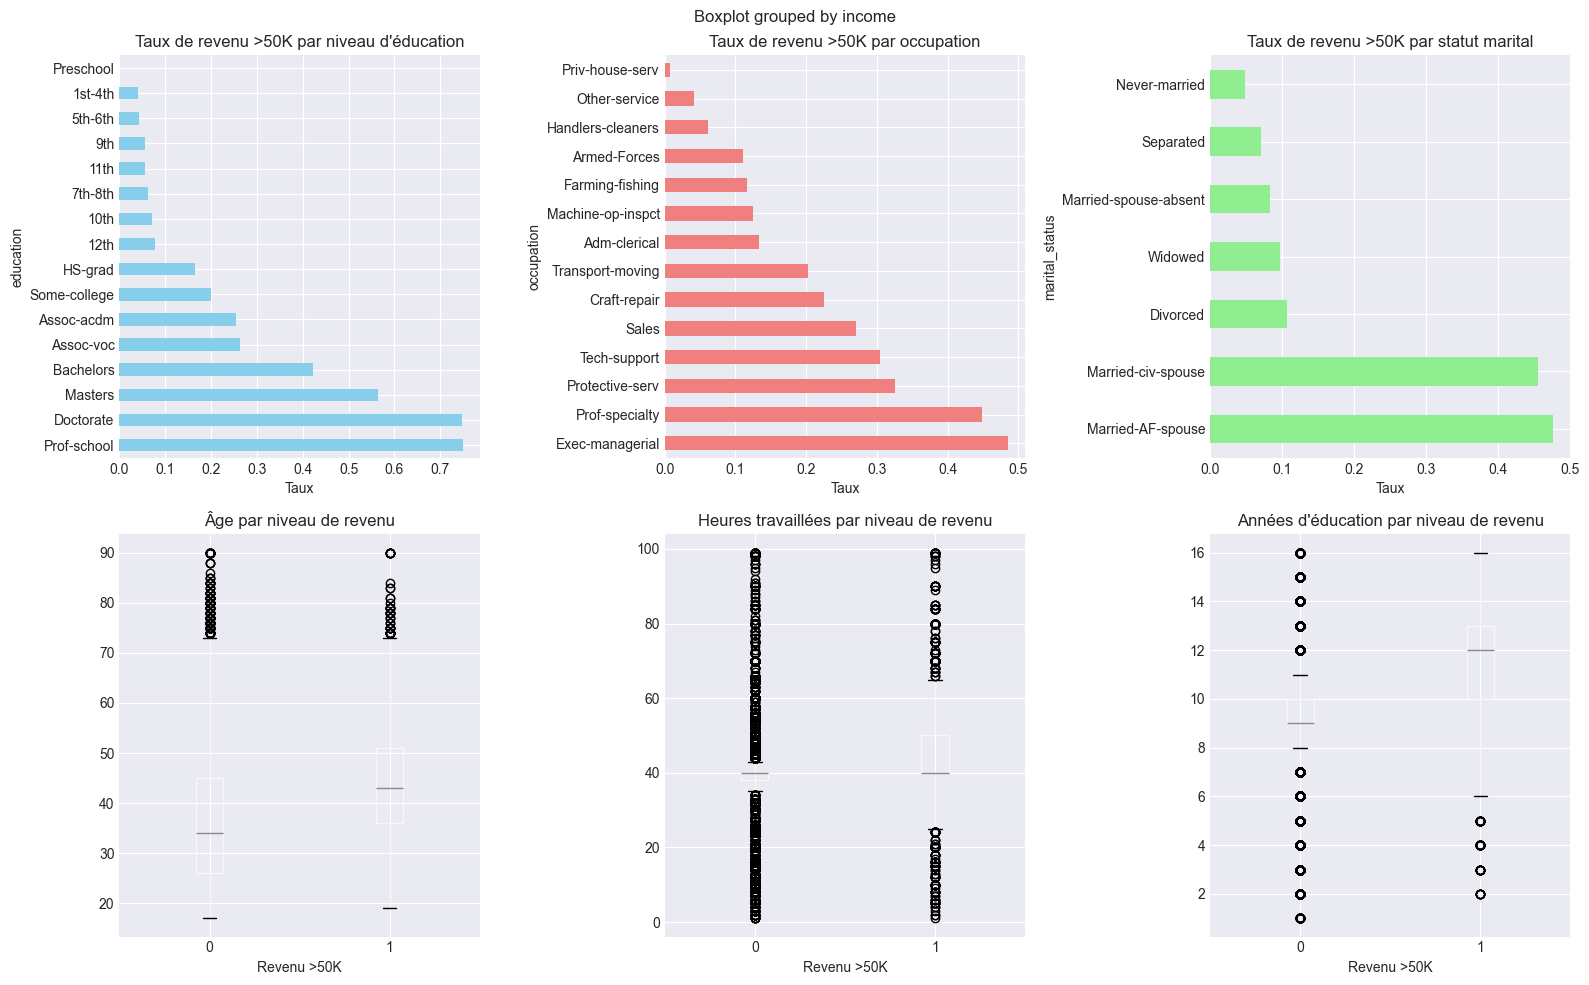

In [13]:
# Visualisation
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Taux de revenu >50K par catégorie
df.groupby("education")["income"].mean().sort_values(ascending=False).plot(
    kind="barh",
    ax=axes[0, 0],
    color="skyblue",
)
axes[0, 0].set_title("Taux de revenu >50K par niveau d'éducation")
axes[0, 0].set_xlabel("Taux")

df.groupby("occupation")["income"].mean().sort_values(ascending=False).plot(
    kind="barh",
    ax=axes[0, 1],
    color="lightcoral",
)
axes[0, 1].set_title("Taux de revenu >50K par occupation")
axes[0, 1].set_xlabel("Taux")

df.groupby("marital_status")["income"].mean().sort_values(ascending=False).plot(
    kind="barh",
    ax=axes[0, 2],
    color="lightgreen",
)
axes[0, 2].set_title("Taux de revenu >50K par statut marital")
axes[0, 2].set_xlabel("Taux")

# Distribution des variables numériques par revenu
df.boxplot(column="age", by="income", ax=axes[1, 0])
axes[1, 0].set_title("Âge par niveau de revenu")
axes[1, 0].set_xlabel("Revenu >50K")

df.boxplot(column="hours_per_week", by="income", ax=axes[1, 1])
axes[1, 1].set_title("Heures travaillées par niveau de revenu")
axes[1, 1].set_xlabel("Revenu >50K")

df.boxplot(column="education_num", by="income", ax=axes[1, 2])
axes[1, 2].set_title("Années d'éducation par niveau de revenu")
axes[1, 2].set_xlabel("Revenu >50K")

plt.tight_layout()
plt.show()

**Observations clés :**
* L'éducation a un fort impact sur le revenu
* Les personnes mariées ont des revenus plus élevés
* Certaines occupations (Exec-managerial, Prof-specialty) sont associées à des revenus >50K
* L'âge et les heures travaillées sont positivement corrélés au revenu

## Modélisation

### Sampling

In [14]:
# Identification des variables catégorielles
cat_features = [
    "workclass",
    "education",
    "marital_status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "native_country",
]

print("\n=== Préparation pour CatBoost ===\n")
print(f"Variables catégorielles : {cat_features}")
print(f"Variables numériques : {numeric_features}")


=== Préparation pour CatBoost ===

Variables catégorielles : ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country']
Variables numériques : ['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']


In [15]:
# Séparation features / target
X = df.drop("income", axis=1)
y = df["income"]

# Split train/test stratifié
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y,
)

In [16]:
print(f"\nTaille train : {X_train.shape} ({len(y_train[y_train == 1])} positifs)")
print(f"Taille test : {X_test.shape} ({len(y_test[y_test == 1])} positifs)")


Taille train : (24129, 14) (6006 positifs)
Taille test : (6033, 14) (1502 positifs)


In [17]:
# Création des Pools CatBoost (structure optimisée)
train_pool = Pool(X_train, y_train, cat_features=cat_features)
test_pool = Pool(X_test, y_test, cat_features=cat_features)

### Algorithme supervisé : CatBoost  

In [18]:
## Premier modèle CatBoost avec paramètres par défaut
# Initialisation
model_baseline = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    loss_function="Logloss",
    eval_metric="AUC",
    random_seed=42,
    verbose=100,
    early_stopping_rounds=50,
)

In [19]:
# Entrainement
model_baseline.fit(train_pool, eval_set=test_pool, plot=False)

0:	test: 0.8746563	best: 0.8746563 (0)	total: 235ms	remaining: 1m 57s
100:	test: 0.9207882	best: 0.9207893 (99)	total: 17.6s	remaining: 1m 9s
200:	test: 0.9248347	best: 0.9248575 (199)	total: 23.4s	remaining: 34.8s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9249125201
bestIteration = 227

Shrink model to first 228 iterations.


In [20]:
# Prédictions
y_pred_baseline = model_baseline.predict(X_test)
y_pred_proba_baseline = model_baseline.predict_proba(X_test)[:, 1]

In [21]:
# Évaluation
print("\n=== Performance du modèle baseline ===\n")
print(classification_report(y_test, y_pred_baseline))
print(f"\nAUC-ROC : {roc_auc_score(y_test, y_pred_proba_baseline):.4f}")


=== Performance du modèle baseline ===

              precision    recall  f1-score   support

           0       0.89      0.94      0.91      4531
           1       0.78      0.65      0.71      1502

    accuracy                           0.87      6033
   macro avg       0.83      0.79      0.81      6033
weighted avg       0.86      0.87      0.86      6033


AUC-ROC : 0.9249


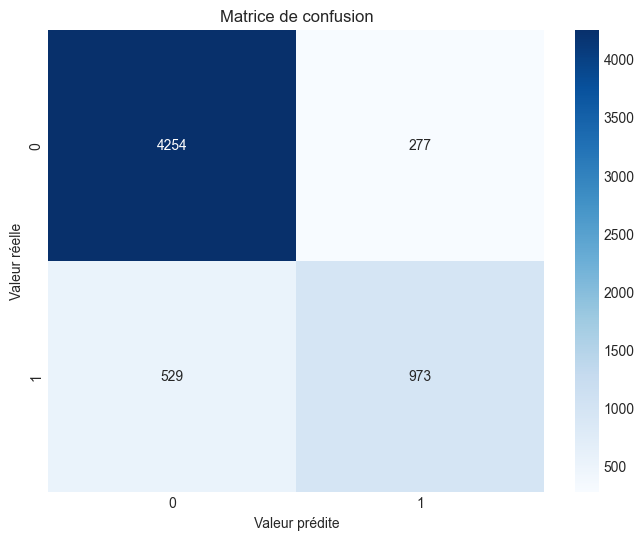

In [22]:
# Matrice de confusion
cm = confusion_matrix(y_test, y_pred_baseline)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matrice de confusion")
plt.ylabel("Valeur réelle")
plt.xlabel("Valeur prédite")
plt.show()

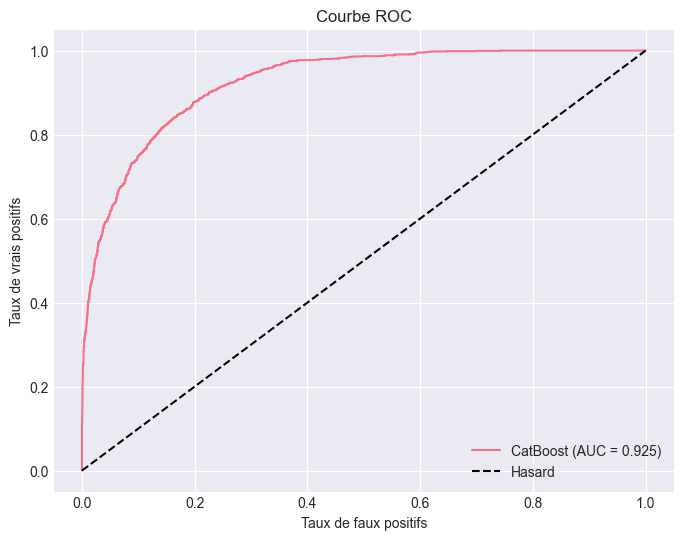

In [23]:
# Courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_baseline)
plt.figure(figsize=(8, 6))
plt.plot(
    fpr,
    tpr,
    label=f"CatBoost (AUC = {roc_auc_score(y_test, y_pred_proba_baseline):.3f})",
)
plt.plot([0, 1], [0, 1], "k--", label="Hasard")
plt.xlabel("Taux de faux positifs")
plt.ylabel("Taux de vrais positifs")
plt.title("Courbe ROC")
plt.legend()
plt.grid(True)
plt.show()


=== Importance des variables ===

           feature  importance
10    capital_gain   22.184166
7     relationship   21.515132
0              age   11.989052
11    capital_loss    8.099907
12  hours_per_week    8.092746
6       occupation    6.768665
5   marital_status    5.823948
4    education_num    5.064122
3        education    3.166436
2           fnlwgt    2.317912
1        workclass    1.725724
9              sex    1.702985
8             race    0.822925
13  native_country    0.726279


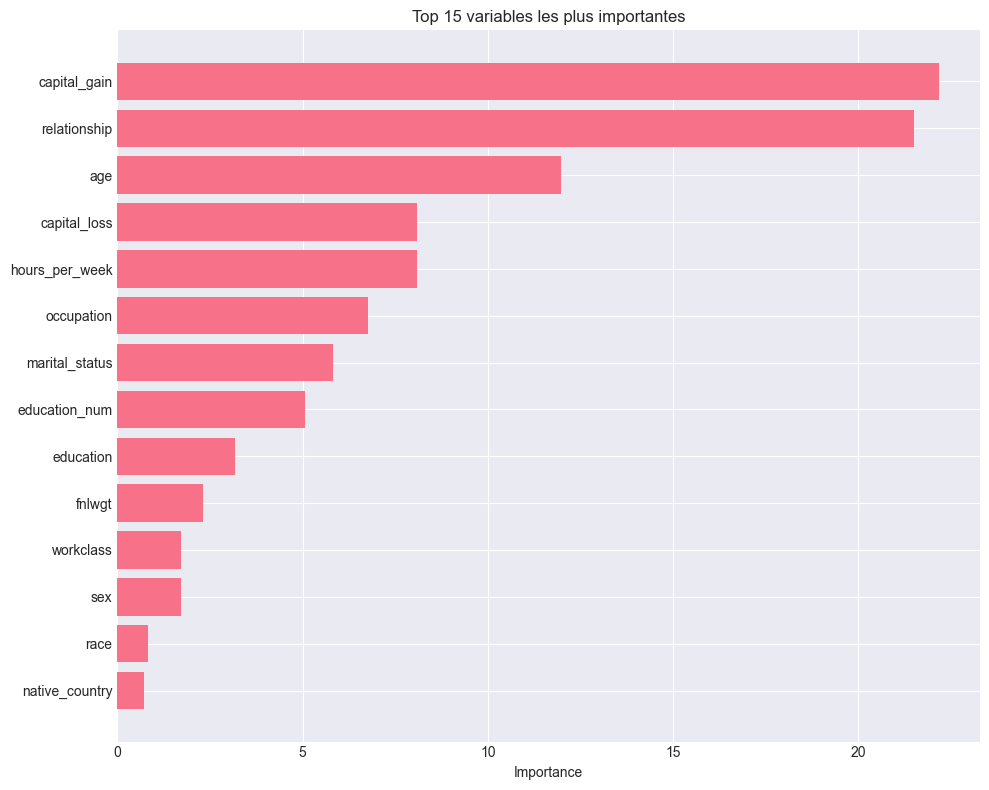

In [24]:
# Importance des variables

print("\n=== Importance des variables ===\n")

feature_importance = model_baseline.get_feature_importance(train_pool)
feature_names = X_train.columns

importance_df = pd.DataFrame(
    {"feature": feature_names, "importance": feature_importance},
).sort_values("importance", ascending=False)

print(importance_df)

# Visualisation
plt.figure(figsize=(10, 8))
plt.barh(importance_df["feature"][:15], importance_df["importance"][:15])
plt.xlabel("Importance")
plt.title("Top 15 variables les plus importantes")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Partie 3 : Exercices

## Exercice 1 : Tuning des hyperparamètres

**Objectif : Améliorer les performances du modèle en testant différentes combinaisons
d'hyperparamètres.**

Hyperparamètres à explorer :
- learning_rate : [0.01, 0.05, 0.1, 0.2]
- depth : [4, 6, 8, 10]
- l2_leaf_reg : [1, 3, 5, 7] (régularisation L2)
- bagging_temperature : [0, 0.5, 1] (randomisation de l'échantillonnage)

Consignes :
1. Utilisez une boucle ou GridSearchCV pour tester différentes combinaisons
2. Comparez les AUC-ROC sur le test set
3. Identifiez la meilleure configuration
4. Entraînez le modèle final avec les meilleurs paramètres

## Exercice 2 : Analyse approfondie

**Contexte : Vous êtes data scientist dans une banque. Le coût d'un faux négatif 
(prêter à quelqu'un qui va faire défaut) est estimé à 10 000€. Le coût d'un 
faux positif (refuser un bon client) est de 500€ (perte d'opportunité).**

**Objectifs :**
1. Calculer le coût total pour différents seuils de classification (0.3, 0.5, 0.7)
2. Déterminer le seuil optimal qui minimise le coût total
3. Produire un rapport de recommandation

Formule :
Coût total = (FN × 10000) + (FP × 500)

Consignes :
- Utilisez y_pred_proba_baseline pour tester différents seuils
- Créez une fonction pour calculer le coût
- Visualisez le coût en fonction du seuil
- Recommandez le meilleur seuil avec justification

In [25]:
best_catboost = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    loss_function="Logloss",
    eval_metric="AUC",
    random_seed=42,
    verbose=100,
    early_stopping_rounds=50,
)

# Entrainement
best_catboost.fit(train_pool, eval_set=test_pool, plot=False)

# Prédictions
y_pred_baseline = best_catboost.predict(X_test)
y_pred_proba_baseline = best_catboost.predict_proba(X_test)[:, 1]

# Évaluation
print("\n=== Performance du modèle baseline ===\n")
print(classification_report(y_test, y_pred_baseline))
print(f"\nAUC-ROC : {roc_auc_score(y_test, y_pred_proba_baseline):.4f}")

0:	test: 0.8746563	best: 0.8746563 (0)	total: 172ms	remaining: 1m 25s
100:	test: 0.9207882	best: 0.9207893 (99)	total: 8.11s	remaining: 32s
200:	test: 0.9248347	best: 0.9248575 (199)	total: 12.4s	remaining: 18.4s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9249125201
bestIteration = 227

Shrink model to first 228 iterations.

=== Performance du modèle baseline ===

              precision    recall  f1-score   support

           0       0.89      0.94      0.91      4531
           1       0.78      0.65      0.71      1502

    accuracy                           0.87      6033
   macro avg       0.83      0.79      0.81      6033
weighted avg       0.86      0.87      0.86      6033


AUC-ROC : 0.9249


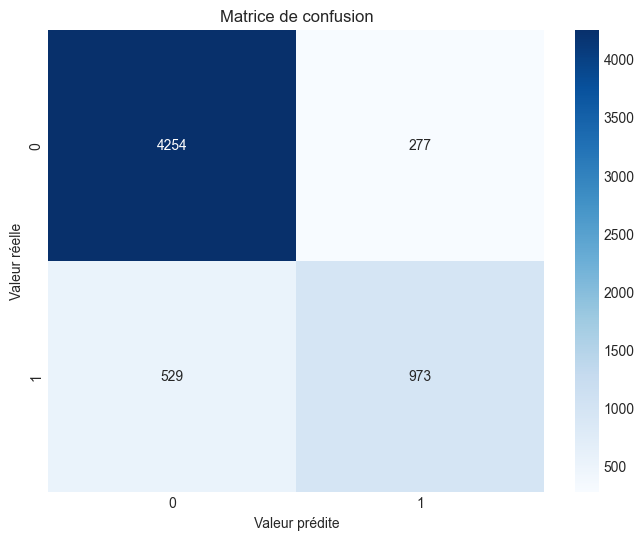

In [26]:
# Matrice de confusion
cm = confusion_matrix(y_test, y_pred_baseline)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matrice de confusion")
plt.ylabel("Valeur réelle")
plt.xlabel("Valeur prédite")
plt.show()

## Exercice 3 : Prédiction du montant de défaut (régression)

**Objectif : Transformer le problème en régression pour prédire le montant 
du défaut potentiel (et pas seulement si/non).**

Étapes :
1. Créer une nouvelle variable cible : 'montant_defaut' 
   - Si défaut = 0 : montant_defaut = 0
   - Si défaut = 1 : montant_defaut = montant_credit * ratio_defaut_simule
   
2. Entraîner un CatBoostRegressor

3. Évaluer avec MAE, RMSE, R²

4. Comparer l'importance des features avec le modèle de classification

In [27]:
# Création de la variable defaut (oubli dans l'énoncé)
df["montant_credit"] = np.random.uniform(3000, 450000)
df["defaut"] = df["capital_gain"] < df["capital_loss"]

df = df.drop(["capital_gain", "capital_loss"], axis=1)

In [28]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Création de la cible de régression
np.random.seed(42)
df["montant_defaut"] = df.apply(
    lambda row: row["montant_credit"] * np.random.uniform(0.3, 0.8)
    if row["defaut"] == 1
    else 0,
    axis=1,
)

# Préparation
X_reg = df.drop(["defaut", "montant_defaut"], axis=1)
y_reg = df["montant_defaut"]

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg,
    y_reg,
    test_size=0.2,
    random_state=42,
)

# Pools
train_pool_reg = Pool(X_train_reg, y_train_reg, cat_features=cat_features)
test_pool_reg = Pool(X_test_reg, y_test_reg, cat_features=cat_features)

# Modèle
model_reg = CatBoostRegressor(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    random_seed=42,
    verbose=100,
)

model_reg.fit(train_pool_reg, eval_set=test_pool_reg)

# Prédictions
y_pred_reg = model_reg.predict(X_test_reg)

# Évaluation
print(f"MAE : {mean_absolute_error(y_test_reg, y_pred_reg):,.2f}€")
print(f"RMSE : {np.sqrt(mean_squared_error(y_test_reg, y_pred_reg)):,.2f}€")
print(f"R² : {r2_score(y_test_reg, y_pred_reg):.4f}")

# Perte attendue totale
perte_totale_reelle = y_test_reg.sum()
perte_totale_predite = y_pred_reg.sum()
print(f"\\nPerte totale réelle : {perte_totale_reelle:,.2f}€")
print(f"Perte totale prédite : {perte_totale_predite:,.2f}€")
print(f"Erreur : {abs(perte_totale_reelle - perte_totale_predite):,.2f}€")

0:	learn: 49203.9724124	test: 50617.1901164	best: 50617.1901164 (0)	total: 41ms	remaining: 20.5s
100:	learn: 48437.1893196	test: 50052.4073304	best: 50038.4930903 (73)	total: 2.54s	remaining: 10s
200:	learn: 47905.0927458	test: 50121.0948143	best: 50038.4930903 (73)	total: 6.04s	remaining: 8.98s
300:	learn: 47372.1749510	test: 50166.1469085	best: 50038.4930903 (73)	total: 9.39s	remaining: 6.21s
400:	learn: 46855.4993995	test: 50270.6663358	best: 50038.4930903 (73)	total: 13.2s	remaining: 3.26s
499:	learn: 46487.9636285	test: 50308.7451900	best: 50038.4930903 (73)	total: 16.3s	remaining: 0us

bestTest = 50038.49309
bestIteration = 73

Shrink model to first 74 iterations.
MAE : 20,089.78€
RMSE : 50,038.49€
R² : 0.0267
\nPerte totale réelle : 66,263,722.75€
Perte totale prédite : 64,040,461.12€
Erreur : 2,223,261.63€



=== Importance des variables ===

           feature  importance
12          income   50.866106
3        education    7.719029
4    education_num    7.679601
2           fnlwgt    5.390006
6       occupation    4.938505
5   marital_status    4.321928
11  native_country    4.066952
0              age    3.823869
10  hours_per_week    3.527171
7     relationship    2.400281
1        workclass    2.350175
8             race    2.238380
9              sex    0.677997
13  montant_credit    0.000000


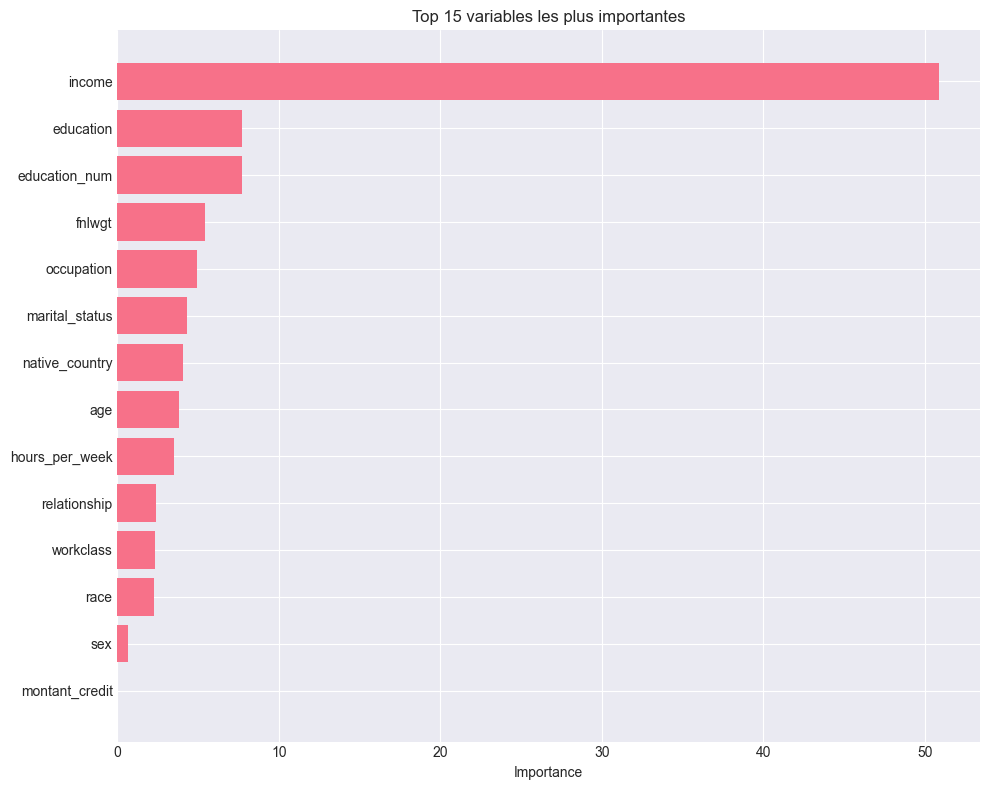

In [29]:
# Importance des variables

print("\n=== Importance des variables ===\n")

feature_importance = model_reg.get_feature_importance(train_pool_reg)
feature_names = X_reg.columns

importance_df = pd.DataFrame(
    {"feature": feature_names, "importance": feature_importance},
).sort_values("importance", ascending=False)

print(importance_df)

# Visualisation
plt.figure(figsize=(10, 8))
plt.barh(importance_df["feature"][:15], importance_df["importance"][:15])
plt.xlabel("Importance")
plt.title("Top 15 variables les plus importantes")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Partie 4 : Techniques avancées (bonus)

## Gestion du déséquilibre des classes

In [30]:
# Option 1 : Pondération automatique
model_weighted = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    random_seed=42,
    verbose=0,
    auto_class_weights="Balanced",
    eval_metric="AUC",
)

model_weighted.fit(train_pool, eval_set=test_pool)

In [31]:
y_pred_weighted = model_weighted.predict(X_test)
y_pred_proba_weighted = model_weighted.predict_proba(X_test)[:, 1]

In [32]:
print("Performance avec class weights :")
print(classification_report(y_test, y_pred_weighted))
print(f"AUC-ROC : {roc_auc_score(y_test, y_pred_proba_weighted):.4f}")

Performance avec class weights :
              precision    recall  f1-score   support

           0       0.94      0.83      0.88      4531
           1       0.63      0.84      0.72      1502

    accuracy                           0.84      6033
   macro avg       0.78      0.84      0.80      6033
weighted avg       0.86      0.84      0.84      6033

AUC-ROC : 0.9253


In [33]:
# Option 2 : scale_pos_weight (pour déséquilibre important)
scale = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
print(f"\nScale pos weight calculé : {scale:.2f}")

model_scaled = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    random_seed=42,
    verbose=0,
    scale_pos_weight=scale,
    eval_metric="AUC",
)

model_scaled.fit(train_pool, eval_set=test_pool)


Scale pos weight calculé : 3.02


## SHAP Values pour l'interprétabilité

In [34]:
# CatBoost a un support natif pour SHAP
shap_values = model_baseline.get_feature_importance(train_pool, type="ShapValues")

In [35]:
# Les shap_values ont la forme (n_samples, n_features + 1)
# La dernière colonne est la valeur de base

print(f"Shape des SHAP values : {shap_values.shape}")

Shape des SHAP values : (24129, 15)


In [36]:
# Importance SHAP moyenne
shap_importance = np.abs(shap_values[:, :-1]).mean(axis=0)
shap_df = pd.DataFrame(
    {"feature": X_train.columns, "shap_importance": shap_importance},
).sort_values("shap_importance", ascending=False)

print("\nImportance SHAP moyenne :")
print(shap_df.head(10))


Importance SHAP moyenne :
           feature  shap_importance
7     relationship         0.833481
0              age         0.763489
10    capital_gain         0.484163
5   marital_status         0.426608
6       occupation         0.415689
12  hours_per_week         0.378604
3        education         0.281114
4    education_num         0.271613
9              sex         0.144403
11    capital_loss         0.133650


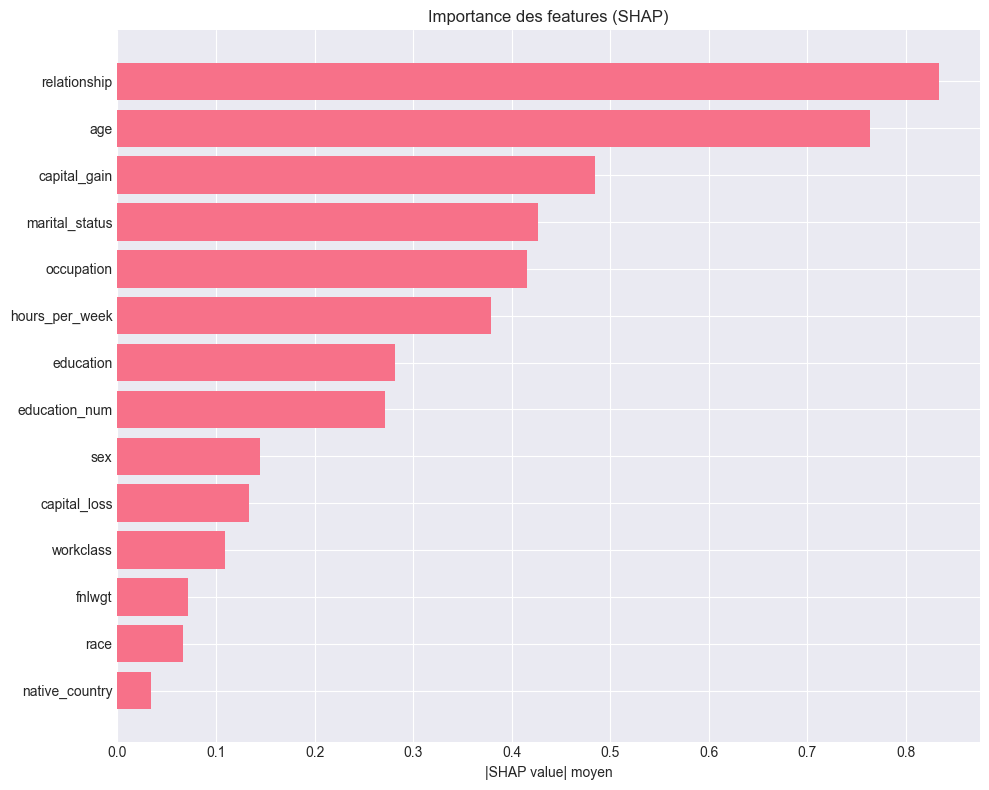

In [37]:
# Visualisation
plt.figure(figsize=(10, 8))
plt.barh(shap_df["feature"][:15], shap_df["shap_importance"][:15])
plt.xlabel("|SHAP value| moyen")
plt.title("Importance des features (SHAP)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()